In [1]:
# from visualizer import get_local
# get_local.activate()

import os
ROOT_PATH="/data/aofei"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
os.environ["TRANSFORMERS_CACHE"] = f"{ROOT_PATH}/huggingface_cache/transformers"
os.environ["HF_HOME"] = f"{ROOT_PATH}/huggingface_cache/transformers"
os.environ["TORCH_HOME"] = f"{ROOT_PATH}/huggingface_cache/torch"


from PIL import Image
# import seaborn as sns
import torch
import torch.nn.functional as F
import json
import copy
import numpy as np

import sys
sys.path.append("/home/avc6555/research/MedH/Mitigation/LVLMs/XrayGPT")


import numpy as np
import torch
import torch.backends.cudnn as cudnn

from xraygpt.common.config import Config
from xraygpt.common.dist_utils import get_rank
from xraygpt.common.registry import registry
from xraygpt.conversation.conversation import Chat, CONV_VISION

# imports modules for registration
from xraygpt.datasets.builders import *
from xraygpt.models import *
from xraygpt.processors import *
from xraygpt.runners import *
from xraygpt.tasks import *

from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):

    def __init__(self, stops=[], encounters=1):
        super().__init__()
        self.stops = stops

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        for stop in self.stops:
            if torch.all((stop == input_ids[0][-len(stop):])).item():
                return True

        return False


/data/aofei/conda/env/minigptv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpu_id = os.environ["CUDA_VISIBLE_DEVICES"]
class Args:
    def __init__(self):
        self.cfg_path="/home/avc6555/research/MedH/Mitigation/LVLMs/XrayGPT/eval_configs/xraygpt_eval.yaml"
        self.options=[]

args = Args()

cfg = Config(args)
model_config = cfg.model_cfg
model_config.device_8bit = gpu_id
model_cls = registry.get_model_class(model_config.arch)
model = model_cls.from_config(model_config).to('cuda')
device = torch.device('cuda')
# CONV_VISION = conv_dict[model_config.model_type]

vis_processor_cfg = cfg.datasets_cfg.openi.vis_processor.train
vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)

stop_words_ids = [torch.tensor([835]).to(device),
                    torch.tensor([2277, 29937]).to(device)]  # '###' can be encoded in two different ways.
stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])

Loading VIT
Loading VIT Done
Loading Q-Former
Loading Q-Former Done
Loading LLAMA


Loading checkpoint shards: 100%|██████████| 2/2 [00:12<00:00,  6.21s/it]


Loading LLAMA Done
Load 15 training prompts
Prompt Example 
###Patient: <Img><ImageHere></Img> Describe the given chest x-ray image in detail. ###Doctor: 
####################################################################################################
Load BLIP2-LLM Checkpoint: /data/aofei/LLM/xray_gpt/xraygpt_pretrained1.pth


In [41]:
prompt = conv.get_prompt()
prompt_segs = prompt.split('<ImageHere>')
seg_tokens = [
    model.llama_tokenizer(
        seg, return_tensors="pt", add_special_tokens=i == 0).to(model.device).input_ids
    # only add bos to the first seg
    for i, seg in enumerate(prompt_segs)
]
[i.size() for i in seg_tokens]

[torch.Size([1, 50]), torch.Size([1, 20])]

In [39]:
def get_context_emb(conv, img_list, model):
    prompt = conv.get_prompt()
    prompt_segs = prompt.split('<ImageHere>')
    seg_tokens = [
        model.llama_tokenizer(
            seg, return_tensors="pt", add_special_tokens=i == 0).to(model.device).input_ids
        # only add bos to the first seg
        for i, seg in enumerate(prompt_segs)
    ]
    seg_embs = [model.llama_model.model.embed_tokens(seg_t) for seg_t in seg_tokens]
    mixed_embs = [emb for pair in zip(seg_embs[:-1], img_list) for emb in pair] + [seg_embs[-1]]
    mixed_embs = torch.cat(mixed_embs, dim=1)
    return mixed_embs

image = "/home/avc6555/research/MedH/Mitigation/LVLMs/llava-med/visualize/images/cat.jpg"
question = "What is the abnormity in this image?"
# question = "What are the main findings and impression of the given x-ray?"
conv = CONV_VISION

if isinstance(image, str):  # is a image path
    raw_image = Image.open(image).convert('RGB')
    image = vis_processor(raw_image).unsqueeze(0).to(device)
elif isinstance(image, Image.Image):
    raw_image = image
    image = vis_processor(raw_image).unsqueeze(0).to(device)
elif isinstance(image, torch.Tensor):
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    image = image.to(device)
img_list = []
image_emb, _ = model.encode_img(image)
img_list.append(image_emb)
conv.messages = []
conv.append_message(conv.roles[0], "<Img><ImageHere></Img>")
# question = "Could you highlight any abnormalities or concerns in this chest x-ray image?"
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
embs = get_context_emb(conv, img_list, model)

begin_idx = 0

embs = embs[:, begin_idx:]

outputs = model.llama_model.generate(
        inputs_embeds=embs,
        max_new_tokens=64,
        stopping_criteria=stopping_criteria,
        num_beams=1,
        do_sample=,
        min_length=1,
        top_p=0.9,
        repetition_penalty=1,
        length_penalty=1,
        temperature=1,
        output_attentions=True, return_dict_in_generate=True
    )
output_token = outputs['sequences'][0]
if output_token[0] == 0:  # the model might output a unknow token <unk> at the beginning. remove it
    output_token = output_token[1:]
if output_token[0] == 1:  # some users find that there is a start token <s> at the beginning. remove it
    output_token = output_token[1:]
output_text = model.llama_tokenizer.decode(output_token, add_special_tokens=False)
output_text = output_text.split('###')[0]  # remove the stop sign '###'
output_text = output_text.split('Doctor:')[-1].strip()

In [40]:
output_text

'Good day! The description of your question suggests that you may have an interest in finding out what the recommended steps are for the treatment of your problem. So, I would be happy to assist you in any way I can. The information provided here is for your consideration only and does not necessarily represent the standard of care for'

In [28]:
output_text

'I am having difficulty getting a clear chest radiograph. Please help me. The cats are so sensitive and may need some sedation. Otherwise, the examination for a primary chest condition is clear.  You are so kind. Thank you. You must be really worried about these findings. I'

In [16]:
output_text

'The given patient has undergone thoracic aorta replacement surgery. The right upper lobe is partially obscured by the gaseous distension of the right lung and a streaky opacity in the right lung base that is likely due to pleural plaque. There is no focal lung'

In [19]:
output_text

"Hi, the clinical findings are consistent with your presentation. If you'd like, you can see the full physical exam findings here for more information. The patient had been diagnosed with asthma, so I had to consider the implications of your presentation. I hope this is helpful. Please feel"

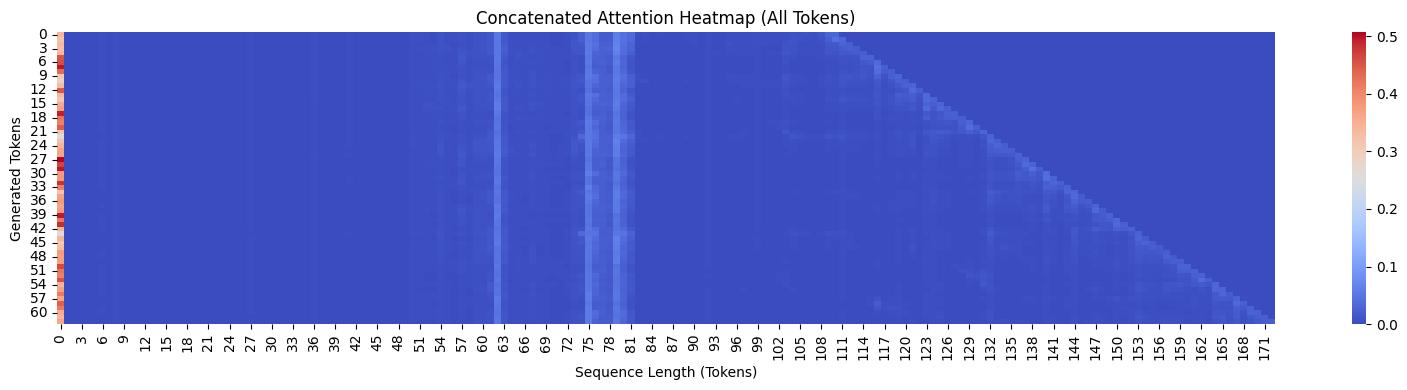

In [8]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def pad_and_concat_attentions(attention_tuple, max_seq_len):
    """
    Pad attention maps with zeros and concatenate them.
    
    Args:
    - attention_tuple: Tuple of attention tensors, where each tensor corresponds to one generated token's attention.
                       Shape: (generated_token_length, layers, 1, heads, 1, seq_len)
    - max_seq_len: The maximum sequence length to pad to.
    
    Returns:
    - concatenated_attentions: Tensor of concatenated attention maps (generated_token_length, seq_len)
    """
    padded_attentions = []
    
    for attn_tensor in attention_tuple:
        # print(attn_tensor.size())
        seq_len = attn_tensor[0].shape[-1]  # Current sequence length for this token
        padding_len = max_seq_len - seq_len
        
        attn_tensor = torch.cat(attn_tensor, 0).mean(0)
        # print(attn_tensor.size())
        # Average over layers and heads
        attn_tensor_avg = attn_tensor.mean(0).squeeze().squeeze().cpu() # Shape: (seq_len,)
        
        # Pad attention tensor with zeros to match max_seq_len
        if padding_len > 0:
            attn_tensor_avg = torch.cat([attn_tensor_avg, torch.zeros(padding_len)], dim=-1)
        
        padded_attentions.append(attn_tensor_avg)
    
    # Concatenate attentions across generated tokens
    concatenated_attentions = torch.stack(padded_attentions, dim=0)
    
    return concatenated_attentions

def draw_concatenated_attention_heatmap(concatenated_attentions):
    """
    Draw a heatmap of concatenated attention scores.
    
    Args:
    - concatenated_attentions: Tensor of concatenated attention scores (generated_token_length, seq_len).
    """
    
    plt.figure(figsize=(16, 4))
    
    # Convert tensor to numpy for plotting
    attention_data = concatenated_attentions.cpu().detach().numpy()
    
    sns.heatmap(attention_data, cmap='coolwarm', cbar=True)
    
    plt.title("Concatenated Attention Heatmap (All Tokens)")
    plt.xlabel("Sequence Length (Tokens)")
    plt.ylabel("Generated Tokens")
    plt.tight_layout()
    plt.show()

# Assume that the output attentions are of the shape (generated_token_length, layers, 1, heads, 1, seq_len)
generated_token_length = len(outputs['attentions'])
max_seq_len = max([attn[0].shape[-1] for attn in outputs['attentions']])  # Max sequence length over all generated tokens

# Pad and concatenate attentions
concatenated_attentions = pad_and_concat_attentions(outputs['attentions'][1:], max_seq_len)

# Draw heatmap
draw_concatenated_attention_heatmap(concatenated_attentions)


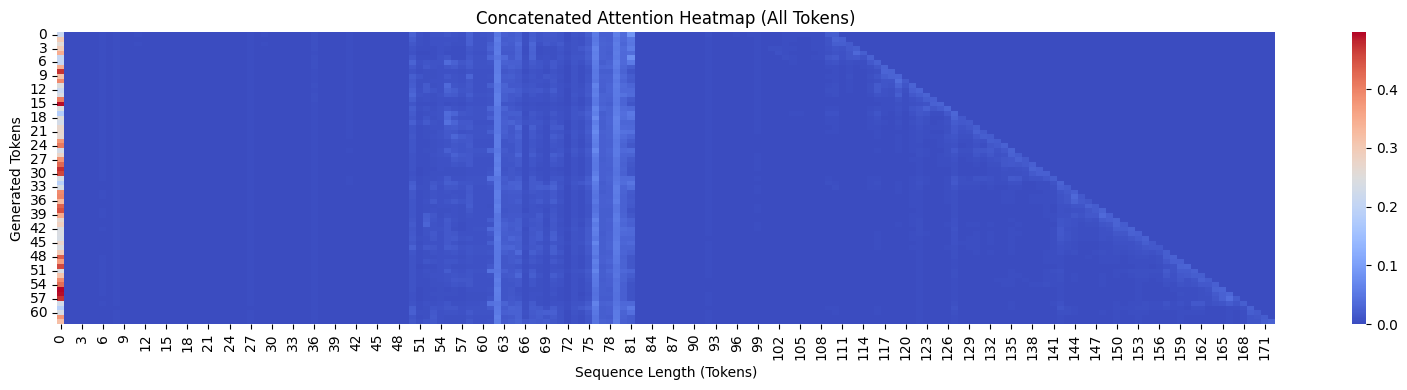

In [14]:
generated_token_length = len(outputs['attentions'])
max_seq_len = max([attn[0].shape[-1] for attn in outputs['attentions']])  # Max sequence length over all generated tokens

# Pad and concatenate attentions
concatenated_attentions = pad_and_concat_attentions(outputs['attentions'][1:], max_seq_len)

# Draw heatmap
draw_concatenated_attention_heatmap(concatenated_attentions)

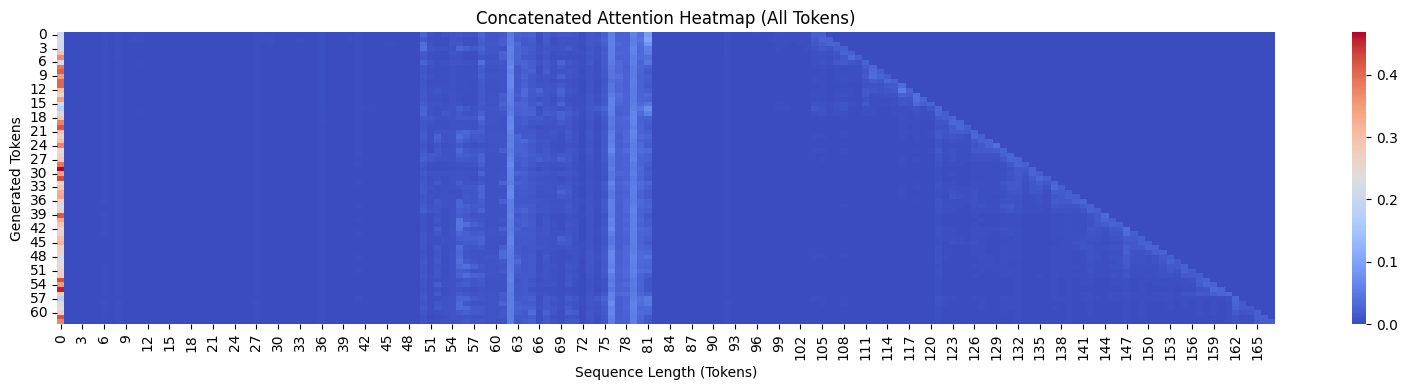

In [17]:
generated_token_length = len(outputs['attentions'])
max_seq_len = max([attn[0].shape[-1] for attn in outputs['attentions']])  # Max sequence length over all generated tokens

# Pad and concatenate attentions
concatenated_attentions = pad_and_concat_attentions(outputs['attentions'][1:], max_seq_len)

# Draw heatmap
draw_concatenated_attention_heatmap(concatenated_attentions)

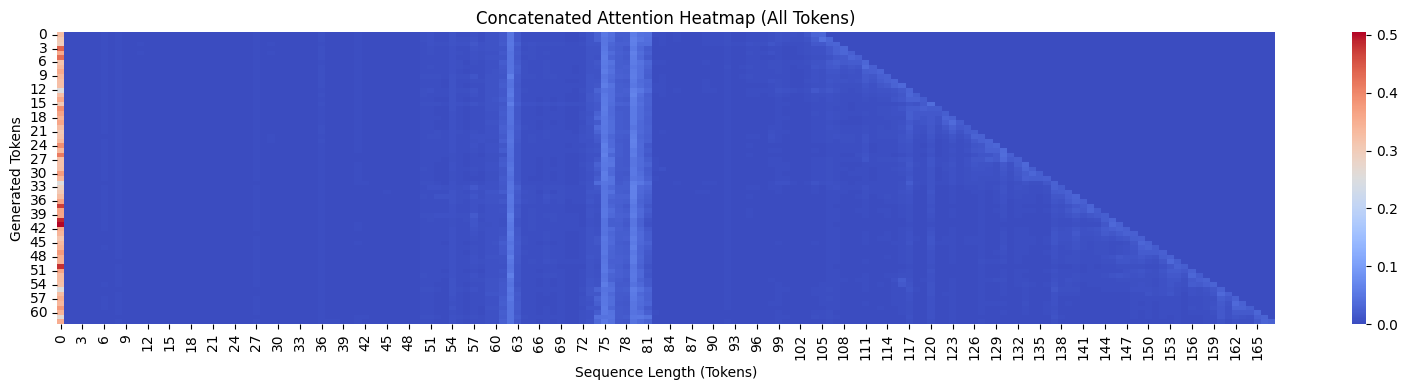

In [20]:
generated_token_length = len(outputs['attentions'])
max_seq_len = max([attn[0].shape[-1] for attn in outputs['attentions']])  # Max sequence length over all generated tokens

# Pad and concatenate attentions
concatenated_attentions = pad_and_concat_attentions(outputs['attentions'][1:], max_seq_len)

# Draw heatmap
draw_concatenated_attention_heatmap(concatenated_attentions)

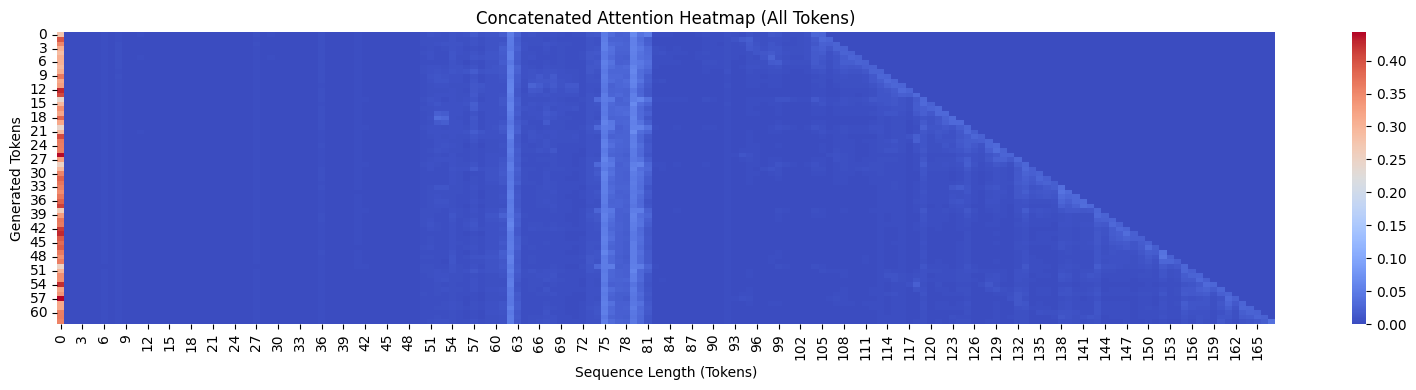

In [24]:
# cat and cat answer

generated_token_length = len(outputs['attentions'])
max_seq_len = max([attn[0].shape[-1] for attn in outputs['attentions']])  # Max sequence length over all generated tokens

# Pad and concatenate attentions
concatenated_attentions = pad_and_concat_attentions(outputs['attentions'][1:], max_seq_len)

# Draw heatmap
draw_concatenated_attention_heatmap(concatenated_attentions)